<div hidden>
$\DeclareMathOperator{\tr}{tr}$
$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
</div>

# Decomposição aditiva de matrizes

Considere novamente problemas de estimação cujo parâmetro tem a estrutura de matriz. Modelamos anteriormente o caso em que o parâmetro tem posto pequeno. Existem aplicações em que vale a pena modelar o parâmetro da forma

$$
B^* = \Gamma^* + S^*,  
$$

onde $\Gamma^*$ é uma matriz de posto $r$ e $S^*$ é uma matriz com no máximo $s$ entradas não-nulas. são matrizes $\mathbb{R}^{d_1\times d_2}$. Neste projeto iremos implementar métodos iterativos para achar a solução do seguinte estimador de mínimos quadrados regularizado:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & f(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}
onde 

$$
f(\Gamma, S) := \frac{1}{2n}\sum_{i=1}^n\left\{
y_i-\tr\left(
X_i^\top(\Gamma + S)
\right)
\right\}^2, 
$$

$(y_1,X_1), \ldots, (y_n,X_n)$ é uma amostra de labels/features em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$. Àcima, $\lambda,\tau,a>0$ são hyper-parâmetros,  

$$
\Vert \Gamma\Vert_N := \sum_{j=1}^{\min\{d_1,d_2\}}\sigma(B),
$$

é a *norma nuclear* da matriz $\Gamma$, onde $\sigma_1(\Gamma)\ge\cdots\ge\sigma_{\min\{d_1,d_2\}}(\Gamma)$ são os valores singulares de $B$. Além disso,  

$$
\Vert \Gamma\Vert_\infty := \max_{(j,k)\in[d_1]\times[d_2]}|\Gamma_{jk}|,
$$

é a *norma $\ell_\infty$* da matriz $\Gamma$ e 

$$
\Vert S\Vert_1 := \sum_{j=1}^{d_1}\sum_{k=1}^{d_2}|S_{jk}|,
$$

é a *norma $\ell_1$* da matriz $S$.


Exemplos de aplicação de variações deste problema incluem [*multi-task learning*](https://medium.com/gumgum-tech/multi-task-learning-what-is-it-how-does-it-work-and-why-does-it-work-294769c457bb) e [*análise multiômica*](https://academic.oup.com/bioinformatics/article/37/16/2259/6154849?login=false).
  

# Soft-Thresholding matricial


Os métodos que veremos para os problemas anteriores se baseam na idéia de *splitting*. Por exemplo, note que o o problema de otimização em PCA robusta exige otimizar em duas variáveis $[\Gamma, S]$. Entretanto otimizar simultaneamente é mais difícil do que otimizar alternadamente. 

Precisaremos computar os operadores proximais das normas nuclear e $\ell_1$. O *operador proximal* da norma $\lambda\Vert\cdot\Vert_N$ com restrição $\Vert\Gamma\Vert_{\infty}\le a$ é 

\begin{equation*}
P_N(W,\lambda,a) = 
\begin{aligned}
& \underset{\Gamma \in \mathbb{R}^{d_1\times d_2}}{\text{armin}}
& & \frac{1}{2}\Vert W - \Gamma \Vert_F^2 + 
\lambda\Vert \Gamma\Vert_N, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a.
\end{aligned}
\end{equation*}

$P_N(W,\lambda,a)$ tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S_a(\gamma,\lambda):=\sign(\gamma)\cdot\min\left\{
\max\{\gamma-\lambda,0\}, a
\right\}.
$$

Àcima, $\sign(\gamma)$ é o sinal de $\gamma$. Seja agora a decomposição de valores singulares (SVD) de $W$:
$$
W = U\cdot D(\gamma_1,\ldots,\gamma_r)\cdot V^\top.
$$
Então, 
$$
P_N(W,\lambda,a) = U\cdot D\left( S_a(\gamma_1,\lambda),\ldots, S_a(\gamma_r,\lambda)\right)\cdot V^\top, 
$$
chamado de matriz *constraint soft-thresholding* de $W$.

O *operador proximal* da norma $\tau\Vert\cdot\Vert_1$ é 

$$
P_1(W,\tau)\in\argmin_{S\in\mathbb{R}^{d_1\times d_2}}\left\{
\frac{1}{2}\Vert W - S\Vert_F^2 + \tau\Vert S\Vert_1
\right\}.
$$

$P_1(W,\tau)$ também tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S(\gamma,\lambda):=\sign(\gamma)\cdot\max\{\gamma-\lambda,0\}.
$$

$P_1(W,\tau)$ é a matriz $d_1\times d_2$ cuja $[j,k]$-ézima entrada é $S(W_{j,k},\tau)$. 

In [41]:
import matplotlib
import numpy as np
import scipy
from scipy.stats import ortho_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
import math
from scipy.linalg import svd

# Exercício 1:

Construa as funções ``soft(x,l)`` que retorna $S(x,\lambda)$ e ``csoft(x,l,a)`` que retorna $S_a(x,\lambda)$. 

In [42]:
# Função para soft-thresholding simples
def soft(x, l):
    """
    Aplica o operador de soft-thresholding S(x, λ).
    Args:
        x (float or np.array): Valor(es) para aplicar o thresholding.
        l (float): Parâmetro λ.
    Returns:
        float or np.array: Valor após aplicação de S(x, λ).
    """
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

# Função para constraint soft-thresholding
def csoft(x, l, a):
    """
    Aplica o operador de constraint soft-thresholding S_a(x, λ).
    Args:
        x (float or np.array): Valor(es) para aplicar o thresholding.
        l (float): Parâmetro λ.
        a (float): Limite superior para os valores absolutos.
    Returns:
        float or np.array: Valor após aplicação de S_a(x, λ).
    """
    return np.sign(x) * np.minimum(np.maximum(np.abs(x) - l, 0), a)

# Teste das funções
x_test = np.array([3.0, -1.5, 0.5, -0.2])
l = 1.0
a = 2.0

print("Soft-thresholding (S(x, λ)):", soft(x_test, l))
print("Constraint soft-thresholding (S_a(x, λ)):", csoft(x_test, l, a))

Soft-thresholding (S(x, λ)): [ 2.  -0.5  0.  -0. ]
Constraint soft-thresholding (S_a(x, λ)): [ 2.  -0.5  0.  -0. ]


# Exercício 2: Gerando dados

Construa uma função ``data_genG(n,d1,d2,r,Gamma_mag)`` que toma $d_1$, $d_2$, posto $r$ e número positivo ``Gamma_mag`` e retorna a matriz $\Gamma^*$ de dimensão $d_1\times d_2$ e posto $r$ com $\Vert\Gamma\Vert_\infty$ no máximo $\Gamma_{mag}/\sqrt{n}$. Ao gerar esta matriz $\Gamma^*$, use a função ```scipy.stats.ortho_group``` para construir duas matrizes $U$ e $V$ aleatórias ortogonais de dimensões $d_1\times r$ e $d_2\times r$ respectivamente; compute $U\cdot D(\Gamma_{mag},\ldots,\Gamma_{mag})\cdot V^\top$ e finalmente, normalize esta matriz entrada por entrada para satisfazer $\Vert\Gamma^*\Vert\le\Gamma_{mag}/\sqrt{n}$.

In [43]:
def data_genG(n, d1, d2, r, Gamma_mag):
    """
    Gera a matriz Γ* de dimensão d1 x d2 e posto r com 
    norma infinita no máximo Gamma_mag / sqrt(n).
    
    Args:
        n (int): Número de amostras.
        d1 (int): Número de linhas da matriz Γ*.
        d2 (int): Número de colunas da matriz Γ*.
        r (int): Posto da matriz Γ*.
        Gamma_mag (float): Valor máximo de ||Γ*||_∞.
        
    Returns:
        np.array: Matriz Γ* gerada.
    """
    # Gera matrizes ortogonais U (d1 x r) e V (d2 x r)
    U = ortho_group.rvs(d1)[:, :r]
    V = ortho_group.rvs(d2)[:, :r]

    # Cria a matriz diagonal D com valores Gamma_mag
    D = np.diag([Gamma_mag] * r)

    # Calcula Γ* = U * D * V^T
    Gamma_star = U @ D @ V.T

    # Normaliza entrada por entrada para garantir ||Γ*||_∞ <= Gamma_mag / sqrt(n)
    max_abs_value = np.max(np.abs(Gamma_star))
    normalization_factor = Gamma_mag / np.sqrt(n) / max_abs_value
    Gamma_star *= normalization_factor

    return Gamma_star

In [44]:
#Exemplo:
n=100
d_1=10
d_2=10
r=5
Gamma_mag=10
Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
Gamma_true.shape, np.max(abs(Gamma_true)), Gamma_true, 

((10, 10),
 1.0,
 array([[ 0.12317531, -0.39254479, -0.09418318, -0.29338366, -0.01766844,
         -0.06566784, -0.03799576, -0.53022168,  0.75302341,  0.37681933],
        [-0.17090852,  0.36399068,  0.35921912,  0.03622408, -0.65528671,
         -0.29973103, -0.030733  ,  0.18769762, -0.89454558,  0.88646794],
        [ 0.3678632 , -0.48557496,  0.37742604, -0.18359735,  0.30922614,
          0.18939824,  0.60379762,  0.91970416, -0.62795305,  0.22535402],
        [-0.20299267, -0.90676475,  0.08079225, -0.37415096,  0.25606424,
         -0.12271015,  0.10080174,  1.        ,  0.32976321,  0.01179198],
        [ 0.47950648,  0.40982893, -0.19500321,  0.44247736,  0.74998127,
          0.48728785,  0.34793952,  0.15464877, -0.1535744 , -0.92845698],
        [-0.01700097,  0.29463451,  0.00900751,  0.19788337,  0.00879966,
         -0.02570283,  0.01468726,  0.24030877, -0.28108371, -0.00967715],
        [-0.04569456,  0.11364946, -0.35764071,  0.21701044,  0.32235543,
         -0.410

# Exercício 3: Gerando dados

Construa uma função ``data_genS(d1,d2,s,S_mag)`` que toma $d_1$, $d_2$, esparsidade $s\in[d_1d_2]$ e número positivo ``S_mag`` e retorna a matriz $d_1\times d_2$ com $s$ entradas iguais a $S_{mag}$ e outras entradas iguais a zero. Escolha as entradas não-nulas aleatoriamente.

In [45]:
def data_genS(d1, d2, s, S_mag):
    """
    Gera uma matriz esparsa d1 x d2 com exatamente s entradas iguais a S_mag
    e as outras entradas iguais a zero. As posições das entradas não-nulas 
    são escolhidas aleatoriamente.
    
    Args:
        d1 (int): Número de linhas da matriz S.
        d2 (int): Número de colunas da matriz S.
        s (int): Número de entradas não-nulas na matriz.
        S_mag (float): Valor das entradas não-nulas.
    
    Returns:
        np.array: Matriz esparsa S gerada.
    """
    # Inicializa a matriz S com zeros
    S = np.zeros((d1, d2))
    
    # Define o número total de elementos na matriz
    total_elements = d1 * d2
    
    # Garante que a esparsidade não ultrapasse o número total de elementos
    if s > total_elements:
        raise ValueError("A esparsidade 's' não pode ser maior que o número de elementos da matriz.")
    
    # Seleciona aleatoriamente s posições para ter o valor S_mag
    indices = np.random.choice(total_elements, s, replace=False)
    
    # Preenche as posições selecionadas com o valor S_mag
    np.put(S, indices, S_mag)
    
    return S

In [46]:
#Exemplo:
d_1=12
d_2=5
s=10
S_mag=10
S_true = data_genS(d_1,d_2,s,S_mag)
S_true

array([[ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0., 10., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0., 10.,  0.],
       [ 0.,  0., 10., 10.,  0.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

# Exercício 4:

Construa uma função ``data_genXe(n,d_1,d_2,Gamma_true,S_true,sd)`` que toma $n$, $d_1$, $d_2$, $\Gamma^*$, $S^*$ e um número positivo ``sd`` e constrói os dados ``X``, uma lista de $n$ matrizes $X_i$ de dimensão $d_1\times d_2$ independentes cujas entradas são iid normais padrão. A função também retorna o vetor ``y`` de dimensão $n$ cujas coordenadas satisfazem

$$
y_i = \tr(X_i^\top (\Gamma^* + S^*)) + \text{sd}\cdot\epsilon_i,
$$
onde $\{\epsilon_i\}_{i=1}^n$ é uma sequência iid de normais padrão. 

In [47]:
def data_genXe(n, d1, d2, Gamma_true, S_true, sd):
    """
    Gera uma lista de n matrizes X de dimensão d1 x d2 com entradas iid normais
    padrão e o vetor y de dimensão n. As coordenadas de y são dadas por:
    
    y_i = tr(X_i^T * (Gamma_true + S_true)) + sd * epsilon_i,
    
    onde epsilon_i são iid normais padrão.
    
    Args:
        n (int): Número de matrizes e amostras.
        d1 (int): Número de linhas das matrizes X.
        d2 (int): Número de colunas das matrizes X.
        Gamma_true (np.array): Matriz Gamma verdadeira (d1 x d2).
        S_true (np.array): Matriz S verdadeira (d1 x d2).
        sd (float): Desvio padrão do ruído normal.
        
    Returns:
        X (list): Lista de n matrizes X_i de dimensão d1 x d2.
        y (np.array): Vetor de dimensão n com as coordenadas y_i.
    """
    # Inicializa a lista de matrizes X e o vetor y
    X = []
    y = np.zeros(n)
    
    # Soma total das matrizes Gamma_true e S_true
    B_true = Gamma_true + S_true
    
    # Gerando os dados
    for i in range(n):
        # Gera uma matriz X_i com entradas iid normais padrão
        X_i = np.random.randn(d1, d2)
        X.append(X_i)
        
        # Gera o ruído epsilon_i
        epsilon_i = np.random.randn()
        
        # Calcula y_i = tr(X_i^T * B_true) + sd * epsilon_i
        y[i] = np.trace(X_i.T @ B_true) + sd * epsilon_i
    
    return X, y

In [48]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = 1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
X,y = data_genXe(n,d_1,d_2,B_true,S_true, sd)

In [49]:
type(X), len(X), X[0].shape

(list, 100, (40, 40))

In [50]:
type(y), len(y), y.shape

(numpy.ndarray, 100, (100,))

# Exercício 5:

Construa uma função `df(Gamma,S)` que retorna o gradiente $\nabla f(\Gamma, S)$.

In [51]:
def df(Gamma, S):
    """
    Calcula o gradiente de f em relação a Gamma e S.
    
    Args:
        Gamma (np.array): Matriz Gamma (d1 x d2).
        S (np.array): Matriz S (d1 x d2).
        
    Returns:
        grad_Gamma (np.array): Gradiente de f em relação a Gamma.
        grad_S (np.array): Gradiente de f em relação a S.
    """
    n = len(X)  # Número de amostras
    d1, d2 = Gamma.shape  # Dimensões das matrizes Gamma e S
    
    # Inicializa os gradientes com zeros
    grad_Gamma = np.zeros((d1, d2))
    grad_S = np.zeros((d1, d2))
    
    # Computa o gradiente somando sobre todas as amostras
    for i in range(n):
        # Resíduo: y_i - tr(X_i^T * (Gamma + S))
        residual = y[i] - np.trace(X[i].T @ (Gamma + S))
        
        # Atualiza os gradientes
        grad_Gamma -= (residual / n) * X[i]
        grad_S -= (residual / n) * X[i]
    
    return grad_Gamma, grad_S

In [52]:
grad_Gamma, grad_S = df(Gamma_true, S_true)
print(grad_Gamma.shape)  # Shape de Gamma
print(grad_S.shape)  # Shape de S

(40, 40)
(40, 40)


# Exercício 6: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima:

\begin{align*}
W_{\Gamma,k+1} &:= \Gamma_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
W_{S,k+1} &:= S_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
\Gamma_{k+1} &:= P_N\left(W_{\Gamma, k+1},\frac{\lambda}{L},a\right), \\
S_{k+1} &:= P_1\left(W_{S, k+1},\frac{\tau}{L}\right).
\end{align*}

Construa uma função ``trace_reg_MD(Df, n,d_1,d_2,X,y,L,lambd,tau,a, Gamma0,S0,t_final)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{t_final}}$ e $S_{\text{t_final}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right),
$$ 
onde $\text{vec}(X_i)$ representa a matrix $d_1\times d_2$ $X_i$ em forma vetorial de dimensão $d_1d_2$.

In [53]:
# Projeção nuclear
def P_N(W, lambd_over_L, a):
    """ 
    Projeção P_N no espaço das matrizes de posto r.
    Args:
        W (np.array): Matriz de entrada.
        lambd_over_L (float): Lambda/L.
        a (float): Parâmetro a para normalizar.
        
    Returns:
        np.array: Matriz após a projeção nuclear.
    """
    U, Sigma, Vt = svd(W, full_matrices=False)
    Sigma_thresh = np.maximum(Sigma - lambd_over_L, 0)  # Thresholding
    return U @ np.diag(Sigma_thresh) @ Vt * min(1, a / np.max(np.abs(W)))

# Projeção soft-thresholding
def P_1(W, tau_over_L):
    """
    Projeção P_1, soft-thresholding, sobre W.
    Args:
        W (np.array): Matriz de entrada.
        tau_over_L (float): Tau/L.
    
    Returns:
        np.array: Matriz após soft-thresholding.
    """
    return np.sign(W) * np.maximum(np.abs(W) - tau_over_L, 0)

# Função do método gradiente proximal
def trace_reg_MD(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    """
    Método do gradiente proximal com splitting para minimizar f(Gamma, S).
    
    Args:
        Df (function): Função que retorna o gradiente.
        n (int): Número de amostras.
        d_1 (int): Dimensão 1 das matrizes.
        d_2 (int): Dimensão 2 das matrizes.
        X (list of np.array): Lista de matrizes X_i de dimensão (d_1 x d_2).
        y (np.array): Vetor y de dimensão n.
        L (float): Fator de aprendizado 1/L.
        lambd (float): Fator de penalização lambda.
        tau (float): Fator de penalização tau.
        a (float): Parâmetro a para a projeção nuclear.
        Gamma0 (np.array): Ponto inicial para Gamma.
        S0 (np.array): Ponto inicial para S.
        t_final (int): Número de iterações.
    
    Returns:
        list: Sequência de normas do gradiente.
        np.array: Último iterado Gamma.
        np.array: Último iterado S.
    """
    # Inicialização
    Gamma_k = Gamma0
    S_k = S0
    norm_grad_seq = []  # Sequência das normas do gradiente

    # Iterações
    for t in range(t_final):
        # Calcula os gradientes
        grad_Gamma, grad_S = Df(Gamma_k, S_k)
        
        # Passos de atualização W
        W_Gamma_k1 = Gamma_k - (1 / L) * grad_Gamma
        W_S_k1 = S_k - (1 / L) * grad_S
        
        # Atualiza com as projeções
        Gamma_k1 = P_N(W_Gamma_k1, lambd / L, a)
        S_k1 = P_1(W_S_k1, tau / L)
        
        # Calcula a norma do gradiente
        norm_grad = np.linalg.norm(grad_Gamma) ** 2 + np.linalg.norm(grad_S) ** 2
        norm_grad_seq.append(norm_grad)
        
        # Atualiza os iterados
        Gamma_k = Gamma_k1
        S_k = S_k1
    
    # Retorna a sequência de normas e os últimos iterados
    return norm_grad_seq, Gamma_k, S_k

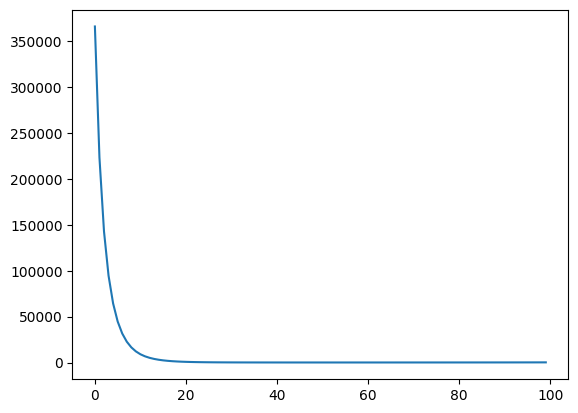

In [54]:
#Exemplo:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))


lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f1 = trace_reg_MD(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)
plt.plot(f1[0])

# Exercício 7: 

O que acontece se $A$ for muito pequeno? 

Se \( A \) for muito pequeno, o valor de \( L \) (calculado como 

\[
L = A \cdot \lambda_{\max}\left( \frac{1}{n} \sum_{i=1}^n \text{vec}(X_i) \text{vec}^\top(X_i) \right)
\])

também será pequeno, o que impacta diretamente o passo \( \frac{1}{L} \) no método de gradiente proximal.

Aqui estão os principais efeitos de um \( A \) muito pequeno:

1. **Passo de Atualização Muito Grande:**  
   Como \( L \) é pequeno, o passo de atualização \( \frac{1}{L} \) se torna muito grande. Isso significa que, em cada iteração, as atualizações para \( \Gamma \) e \( S \) serão muito grandes. Isso pode fazer com que o algoritmo "pule" o ponto ótimo em vez de convergir suavemente. Na prática, isso pode causar oscilações nos iterados ou até instabilidade, levando a um comportamento divergente.

2. **Dificuldade em Convergir:**  
   Se o passo for grande demais, o método pode não convergir ou levar mais tempo para encontrar uma solução, pois os iterados \( \Gamma \) e \( S \) podem se afastar do ótimo em vez de se aproximar dele.

3. **Perda de Precisão:**  
   Com um \( L \) pequeno, o algoritmo pode perder precisão nas aproximações, uma vez que o gradiente é atualizado de forma agressiva, e as iterações podem não capturar as nuances do problema de otimização, resultando em uma solução final menos precisa.

### Solução:
Para garantir uma convergência estável e eficiente, é necessário ajustar \( A \) de forma que o passo \( \frac{1}{L} \) não seja nem muito grande nem muito pequeno. Normalmente, \( A \geq 1 \) é escolhido para garantir que o passo seja adequado. Se \( A \) for pequeno demais, é recomendável aumentá-lo até observar um comportamento estável do algoritmo, onde ele converge de maneira suave para a solução ótima.

# Exercício 8: 

Agora, vamos usar o método gradiente proximal com splitting *acelerado*: iniciando de `[Gamma0,S0]=[Zg0,Zs0]` e $t_0=1$:

\begin{align*}
Z_{\Gamma, k+1}&:= P_N\left(
\Gamma_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\lambda}{L}, a
\right),\\
Z_{S, k+1}&:= P_1\left(
S_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\tau}{L}
\right),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
\Gamma_{k+1} &:= Z_{\Gamma, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{\Gamma, k+1} - Z_{\Gamma, k}),\\
S_{k+1} &:= Z_{S, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{S, k+1} - Z_{S, k}).
\end{align*}

Construa uma função ``trace_reg_MD_acc(Df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{t_final}}$ e $S_{\text{t_final}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right).
$$  

In [55]:
def P_N(Gamma, lambda_val, a):
    U, s, Vt = np.linalg.svd(Gamma, full_matrices=False)
    s = np.maximum(s - lambda_val, 0)  # Soft-thresholding
    return U @ np.diag(s) @ Vt

def P_1(S, tau):
    return np.sign(S) * np.maximum(np.abs(S) - tau, 0)

def trace_reg_MD_acc(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    Gamma = Gamma0
    S = S0
    Zg = Gamma0
    Zs = S0
    t = 1
    
    norm_gradients = []
    
    for k in range(t_final):
        # Gradiente
        grad_Gamma, grad_S = Df(Gamma, S)
        
        # Atualização de Z
        Zg_new = P_N(Gamma - (1/L)*grad_Gamma, lambd/L, a)
        Zs_new = P_1(S - (1/L)*grad_S, tau/L)
        
        # Verificação se as projeções retornaram None
        if Zg_new is None or Zs_new is None:
            print(f"Erro na iteração {k}, Zg_new ou Zs_new é None!")
            break
        
        # Atualização de t e dos iterados
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        Gamma_new = Zg_new + (t - 1) / t_new * (Zg_new - Zg)
        S_new = Zs_new + (t - 1) / t_new * (Zs_new - Zs)
        
        # Armazenamento para análise de convergência
        norm_gradients.append(np.linalg.norm(grad_Gamma)**2 + np.linalg.norm(grad_S)**2)
        
        # Atualizar os valores para a próxima iteração
        Gamma, S = Gamma_new, S_new
        Zg, Zs = Zg_new, Zs_new
        t = t_new
    
    return norm_gradients, Gamma, S

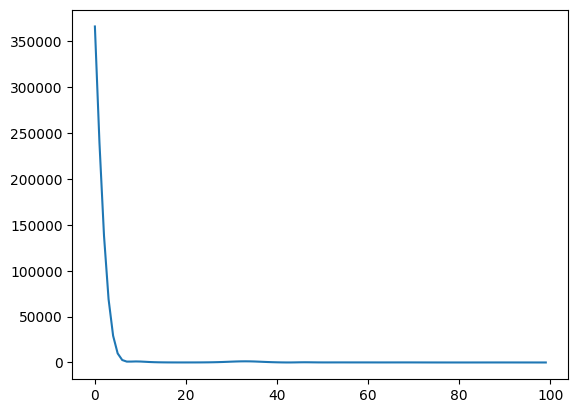

In [56]:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))

lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f2 = trace_reg_MD_acc(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)
plt.plot(f2[0])

# Exercício 9: 

Implemente num mesmo gráfico os erros $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ de cada método em função no número de iterações.

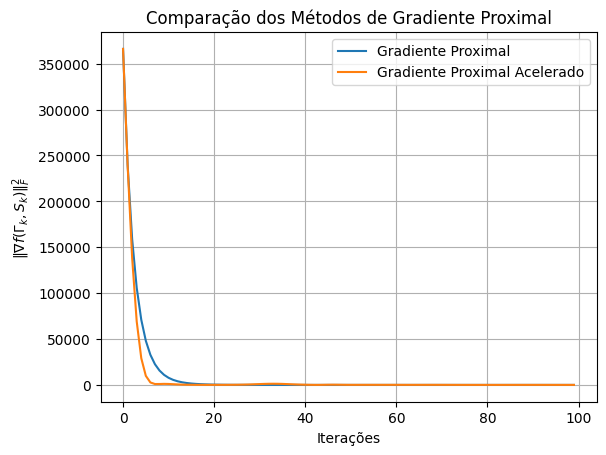

In [57]:
def trace_reg_MD(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    Gamma = Gamma0
    S = S0
    norm_gradients = []
    
    for k in range(t_final):
        # Gradiente
        grad_Gamma, grad_S = Df(Gamma, S)
        
        # Atualização dos iterados
        Gamma_new = Gamma - (1/L) * grad_Gamma
        S_new = S - (1/L) * grad_S
        
        # Armazenamento para análise de convergência
        norm_gradients.append(np.linalg.norm(grad_Gamma)**2 + np.linalg.norm(grad_S)**2)
        
        # Atualizar os valores para a próxima iteração
        Gamma, S = Gamma_new, S_new
    
    return norm_gradients, Gamma, S

def trace_reg_MD_acc(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    Gamma = Gamma0
    S = S0
    Zg = Gamma0
    Zs = S0
    t = 1
    norm_gradients = []
    
    for k in range(t_final):
        # Gradiente
        grad_Gamma, grad_S = Df(Gamma, S)
        
        # Atualização de Z
        Zg_new = P_N(Gamma - (1/L) * grad_Gamma, lambd/L, a)
        Zs_new = P_1(S - (1/L) * grad_S, tau/L)
        
        # Atualização de t e dos iterados
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        Gamma_new = Zg_new + (t - 1) / t_new * (Zg_new - Zg)
        S_new = Zs_new + (t - 1) / t_new * (Zs_new - Zs)
        
        # Armazenamento para análise de convergência
        norm_gradients.append(np.linalg.norm(grad_Gamma)**2 + np.linalg.norm(grad_S)**2)
        
        # Atualizar os valores para a próxima iteração
        Gamma, S = Gamma_new, S_new
        Zg, Zs = Zg_new, Zs_new
        t = t_new
    
    return norm_gradients, Gamma, S

# Parâmetros do problema
Gamma0 = np.ones((d_1, d_2))
S0 = np.ones((d_1, d_2))
t_final = 100

# Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4 * np.max(la.eigvalsh(sum(aux) / n))

lambd = sd * np.sqrt((d_1 + d_2) / n)
a = Gamma_mag / np.sqrt(n)
tau = sd * np.sqrt(np.log(d_1 * d_2) / n) + Gamma_mag / np.sqrt(n)

# Executando os métodos
f1 = trace_reg_MD(df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final)
f2 = trace_reg_MD_acc(df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final)

# Plotando os erros (normas dos gradientes) de cada método
plt.plot(f1[0], label="Gradiente Proximal")
plt.plot(f2[0], label="Gradiente Proximal Acelerado")
plt.xlabel("Iterações")
plt.ylabel(r"$\Vert\nabla f(\Gamma_k, S_k)\Vert_F^2$")
plt.title("Comparação dos Métodos de Gradiente Proximal")
plt.legend()
plt.grid(True)
plt.show()

# PCA robusta

O modelo anterior é *supervisionado*. Em *visão computacional*, um modelo relacionando mas não-supervisionado consiste em estimar cada uma das componentes $[\Gamma^*,S^*]$ tendo apenas uma medição ruidosa da soma $B^*=\Gamma^*+S^*$, por exemplo, ao separar de uma foto um carro (image esparsa) do ambiente (imagem de posto pequeno):

![](Robust-PCA.png)

Neste caso, resolvemos:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & F(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}

onde 

$$
F(\Gamma,S) = \frac{1}{2}\Vert Y - (\Gamma+S)\Vert_F^2, 
$$

$Y$ é uma matriz de dados em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$, por exemplo, uma imagem ruidosa. Aplicações incluem *vigilância por vídeos*, *reconhecimento facial*, *topic modelling* (incluindo *latent semantic analysis* e *sentiment analysis*) e *recomendação de sistemas* sujeito a dados corruptos. Veja e.g. [Robust PCA?](https://arxiv.org/abs/0912.3599) e [Video](https://www.youtube.com/watch?v=yDpz0PqULXQ).

# Exercício 10:

Construa uma função ``data_genYe(n,d_1,d_2,B_true,sd)`` que toma $n$, $d_1$, $d_2$, $B^*$, e um número positivo ``sd`` e constrói a matriz de dados ``Y`` tal que

$$
Y = B^* + \text{sd}\cdot\Xi,
$$

onde $\Xi$ é uma matriz $d_1\times d_2$ cujas entradas são iid $N(0,1)$. NOTA: Iremos usar as mesmas funções anteriores para gerar $\Gamma^*$ e $S^*$.

In [58]:
def data_genYe(n, d_1, d_2, B_true, sd):
    """
    Gera a matriz de dados Y com ruído.
    
    Parâmetros:
    - n: número de amostras (exemplo: número de imagens)
    - d_1, d_2: dimensões da matriz (tamanho da imagem)
    - B_true: matriz verdadeira B* (soma de Gamma* e S*)
    - sd: desvio padrão do ruído

    Retorna:
    - Y: matriz de dados com ruído
    """
    # Gera uma matriz Xi de ruidosas entradas N(0,1)
    Xi = np.random.randn(n, d_1, d_2)
    
    # Gera a matriz Y com ruído
    Y = B_true + sd * Xi
    
    return Y

In [59]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = .1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
Y = data_genYe(n,d_1,d_2,B_true,sd)

In [60]:
Y.shape, Y

((100, 40, 40),
 array([[[ 5.19405260e-01,  1.58761906e-01, -1.94372141e-02, ...,
           1.62962911e-01, -4.40320937e-01,  3.96470893e-02],
         [-5.63900912e-01, -2.26683684e-01, -1.88081464e-01, ...,
          -4.79948893e-02,  1.14125987e-01, -3.04694058e-02],
         [-7.82059666e-02, -1.84185572e-01, -2.54631840e-01, ...,
           1.05928505e-01,  2.18401914e-01, -3.47282741e-01],
         ...,
         [-5.94228362e-01,  1.53126209e-01, -1.06959913e-01, ...,
           2.93676928e-02, -2.69699258e-01,  6.23236488e-01],
         [-1.79204125e-01, -5.34593596e-02,  1.01953725e-01, ...,
           2.71260228e-01, -2.41530529e-01, -3.56355692e-01],
         [ 3.89660489e-02, -3.48239966e-02, -1.17043002e-01, ...,
          -1.92874599e-01,  4.04387235e-02,  4.33423021e-01]],
 
        [[ 3.81042857e-01,  2.32837732e-01, -8.77148450e-02, ...,
           3.39308282e-01, -1.69687351e-01, -1.68017998e-01],
         [-3.60307648e-01, -3.30520760e-01,  2.55283377e-02, ...,
     

# Exercício 11:

Construa uma função `dF(Gamma,S)` que retorna o gradiente $\nabla F(\Gamma,S)$.

In [61]:
def dF(Gamma, S, Y):
    """
    Calcula o gradiente de F(Gamma, S) em relação a Gamma e S.
    
    Parâmetros:
    - Gamma: a matriz Gamma.
    - S: a matriz S.
    - Y: a matriz de dados ruidosa Y.
    
    Retorna:
    - grad_Gamma: gradiente de F em relação a Gamma.
    - grad_S: gradiente de F em relação a S.
    """
    # Cálculo do gradiente em relação a Gamma e S
    grad_Gamma = -(Y - (Gamma + S))
    grad_S = grad_Gamma  # O gradiente em relação a S é igual ao de Gamma
    
    return grad_Gamma, grad_S

# Exercício 12: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima. Ele tem exatamente a mesma expressão do Exercício 6 mas usando $\nabla F(\Gamma,S)$. Implemente o algoritmo com

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $1/L$. PERGUNTA: Exiba um limite aproximado em que para $L$ os métodos convergem e para um $L$ próximo os métodos não convergem. 

Em seguida, implemente o método gradiente proximal com splitting acelerado: é o mesmo que o exercício 8 mas usando $\nabla F(\Gamma,S)$.

Finalmente, plote num mesmo gráfico a sequência de erros $\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ para os dois métodos.

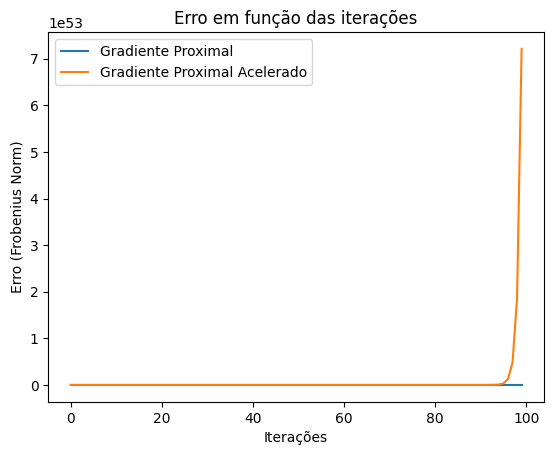

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Função de custo F e gradiente
def F(Gamma, S, Y):
    return 0.5 * np.linalg.norm(Y - (Gamma + S), 'fro')**2

def dF(Gamma, S, Y):
    grad_Gamma = -(Y - (Gamma + S))
    grad_S = grad_Gamma
    return grad_Gamma, grad_S

# Projeções
def P_N(W, lam, a):
    return np.clip(W, -a, a)

def P_1(W, tau):
    return np.sign(W) * np.maximum(np.abs(W) - tau, 0)

# Método de Gradiente Proximal com Splitting
def trace_reg_MD(Df, n, d_1, d_2, X, Y, L, lambd, tau, a, Gamma0, S0, t_final):
    Gamma = Gamma0
    S = S0
    errors = []

    for k in range(t_final):
        grad_Gamma, grad_S = Df(Gamma, S, Y)
        
        W_Gamma = Gamma - (1/L) * grad_Gamma
        W_S = S - (1/L) * grad_S
        
        Gamma = P_N(W_Gamma, lambd/L, a)
        S = P_1(W_S, tau/L)
        
        error = np.linalg.norm(grad_Gamma, 'fro')**2
        errors.append(error)
    
    return errors, Gamma, S

# Método Gradiente Proximal Acelerado
def trace_reg_MD_acc(Df, n, d_1, d_2, X, Y, L, lambd, tau, a, Gamma0, S0, t_final):
    Gamma = Gamma0
    S = S0
    Z_Gamma = Gamma
    Z_S = S
    t = 1
    errors = []

    for k in range(t_final):
        grad_Gamma, grad_S = Df(Gamma, S, Y)
        
        Z_Gamma_next = P_N(Gamma - (1/L) * grad_Gamma, lambd/L, a)
        Z_S_next = P_1(S - (1/L) * grad_S, tau/L)
        
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2
        Gamma = Z_Gamma_next + ((t - 1) / t_next) * (Z_Gamma_next - Z_Gamma)
        S = Z_S_next + ((t - 1) / t_next) * (Z_S_next - Z_S)
        
        t = t_next
        
        error = np.linalg.norm(grad_Gamma, 'fro')**2
        errors.append(error)
    
    return errors, Gamma, S

# Parâmetros
d_1 = 40
d_2 = 40
n = 100
Gamma_mag = 10
S_mag = 10
sd = 0.1
t_final = 100
Gamma0 = np.ones((d_1, d_2))
S0 = np.ones((d_1, d_2))

# Gerando os dados
Gamma_true = np.random.randn(d_1, d_2)
S_true = np.random.randn(d_1, d_2)
B_true = Gamma_true + S_true
Y = B_true + sd * np.random.randn(d_1, d_2)

# Cálculo de L
aux = []
for i in range(n):
    xi = np.asarray(Y)
    aux.append(xi @ xi.T)
L = 4 * np.max(np.linalg.eigvals(sum(aux) / n))

lambd = sd * np.sqrt((d_1 + d_2) / n)
a = Gamma_mag / np.sqrt(n)
tau = sd * np.sqrt(np.log(d_1 * d_2) / n) + Gamma_mag / np.sqrt(n)

# Chamando as funções
errors_md, Gamma_md, S_md = trace_reg_MD(dF, n, d_1, d_2, Y, Y, L, lambd, tau, a, Gamma0, S0, t_final)
errors_md_acc, Gamma_md_acc, S_md_acc = trace_reg_MD_acc(dF, n, d_1, d_2, Y, Y, L, lambd, tau, a, Gamma0, S0, t_final)

# Plotando o gráfico
plt.plot(errors_md, label='Gradiente Proximal')
plt.plot(errors_md_acc, label='Gradiente Proximal Acelerado')
plt.xlabel('Iterações')
plt.ylabel('Erro (Frobenius Norm)')
plt.legend()
plt.title('Erro em função das iterações')
plt.show()

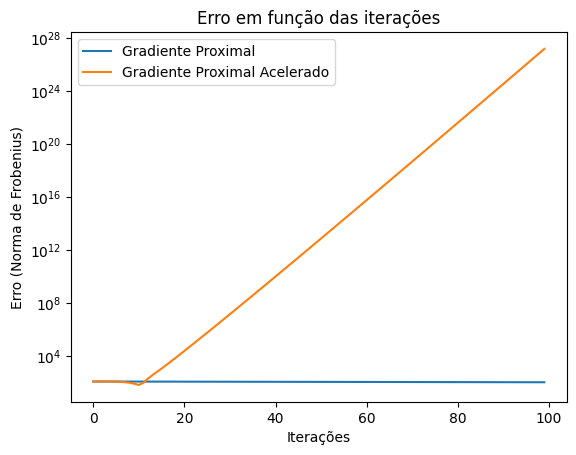

In [ ]:
#Outro teste
# Cálculo de L
aux = []
for i in range(n):
    xi = np.asarray(Y)
    aux.append(xi @ xi.T)
L = 4 * np.max(np.linalg.eigvals(sum(aux) / n))

lambd = sd * np.sqrt((d_1 + d_2) / n)
a = Gamma_mag / np.sqrt(n)
tau = sd * np.sqrt(np.log(d_1 * d_2) / n) + Gamma_mag / np.sqrt(n)

# Chamando as funções
errors_md, Gamma_md, S_md = trace_reg_MD(dF, n, d_1, d_2, Y, Y, L, lambd, tau, a, Gamma0, S0, t_final)
errors_md_acc, Gamma_md_acc, S_md_acc = trace_reg_MD_acc(dF, n, d_1, d_2, Y, Y, L, lambd, tau, a, Gamma0, S0, t_final)

# Plotando o gráfico com escala logarítmica
plt.plot(errors_md, label='Gradiente Proximal')
plt.plot(errors_md_acc, label='Gradiente Proximal Acelerado')
plt.xlabel('Iterações')
plt.ylabel('Erro (Norma de Frobenius)')
plt.yscale('log')  # Escala logarítmica para uma melhor visualização
plt.legend()
plt.title('Erro em função das iterações')
plt.show()
